In [1]:
import os
import copy
import glob
import time
import itertools
import pydotplus
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from boruta import BorutaPy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,LeaveOneGroupOut,GroupKFold,StratifiedGroupKFold
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,classification_report

###########指標の種類
param_base=["deg","base","ST"]
###基本情報すべてのリスト
base=['疾患名', '手術有無','発症部位', '麻痺側', '発症からの期間(日）', '性別', '年齢', '身長(m)', '体重(kg)','靴装着時の転子果長(m)', '本人用装具の有無（ある場合は種類記載）', 'リハ中の歩行様式（杖，装具の有無など）', 'FAC','下肢BRS', 'SIAS-M. hip', 'SIAS-M. knee', 'SIAS-M. ankle','SIAS-M. total', '下肢表在感覚', '下肢深部感覚', '下肢motricity index. Hip','下肢motricity index. Knee', '下肢motricity index. Ankle','下肢motricity index. Total', 'Trunk control test (麻痺側寝返り）','Trunk control test (非麻痺側寝返り）', 'Trunk control test (背臥位から端坐位）','Trunk control test (接地なしでの座位保持)', 'Trunk control test. Total','足MAS 背屈時', '足MAS 底屈時', '膝MAS 伸展時', '膝MAS 屈曲時', '既往歴','計測中の歩行補助具（杖など記載/無）']
###使用する関節角度指標のリスト
deg_index=['contact way','hip_CCC', 'knee_CCC', 'ankle_CCC', 'hip_range', 'knee_range','ankle_range', 'side_range', 'hip_max_LR', 'hip_max_SS＋PS','hip_max_SW', 'hip_min_LR', 'hip_min_SS＋PS', 'hip_min_SW','knee_max_LR', 'knee_max_SS＋PS', 'knee_max_SW', 'knee_min_LR','knee_min_SS＋PS', 'knee_min_SW', 'ankle_max_LR', 'ankle_max_SS＋PS','ankle_max_SW', 'ankle_min_LR', 'ankle_min_SS＋PS', 'ankle_min_SW','side_max_LR', 'side_max_SS＋PS', 'side_max_SW', 'side_min_LR','side_min_SS＋PS', 'side_min_SW','perc_hip_max_LR', 'perc_hip_max_SS＋PS', 'perc_hip_max_SW','perc_hip_min_LR', 'perc_hip_min_SS＋PS', 'perc_hip_min_SW','perc_knee_max_LR', 'perc_knee_max_SS＋PS', 'perc_knee_max_SW','perc_knee_min_LR', 'perc_knee_min_SS＋PS', 'perc_knee_min_SW','perc_ankle_max_LR', 'perc_ankle_max_SS＋PS', 'perc_ankle_max_SW','perc_ankle_min_LR', 'perc_ankle_min_SS＋PS', 'perc_ankle_min_SW','perc_side_max_LR', 'perc_side_max_SS＋PS', 'perc_side_max_SW','perc_side_min_LR', 'perc_side_min_SS＋PS', 'perc_side_min_SW','taikan_max_SS＋PS''tla_small_max_LR', 'tla_small_max_SS＋PS', 'tla_small_max_SW','tla_small_min_LR', 'tla_small_min_SS＋PS', 'tla_small_min_SW','perc_taikan_max_LR', 'perc_taikan_max_SS＋PS', 'perc_taikan_max_SW','perc_taikan_min_LR', 'perc_taikan_min_SS＋PS', 'perc_taikan_min_SW','perc_tla_small_max_LR', 'perc_tla_small_max_SS＋PS','perc_tla_small_max_SW', 'perc_tla_small_min_LR','taikan_max_LR','perc_tla_small_min_SS＋PS', 'perc_tla_small_min_SW','taikan_range', 'tla23_range','hip_max', 'knee_max', 'ankle_max', 'side_max', 'taikan_max','tla23_max', 'hip_min', 'knee_min', 'ankle_min', 'side_min','taikan_min', 'tla23_min', 'hip_HC', 'knee_HC', 'ankle_HC', 'side_HC','taikan_HC', 'tla23_HC']
###使用する時空間指標のリスト
ST_index=['Step', 'Step_other', 'Step_raito','SW', 'ST', 'SW_O','ST_O', 'SW_raito', 'ST_raito', 'T', 'V', 'STRIDE', 'cadence','Time_LR','Time_SS+PS', 'Time_SW','SW%', 'ST%', 'SW_O%','ST_O%', 'Time_LR%', 'Time_SS+PS%', 'Time_SW%']
###使用する基本情報のリスト
base_index=["発症からの期間(日）","身長(m)","年齢","体重(kg)",'FAC','下肢BRS',  'SIAS-M. total','SIAS-M. hip', 'SIAS-M. knee', 'SIAS-M. ankle', '下肢表在感覚','下肢深部感覚', '下肢motricity index. Ankle',"下肢motricity index. Hip","下肢motricity index. Knee","下肢motricity index. Total",'足MAS 背屈時', '足MAS 底屈時', '膝MAS 伸展時', '膝MAS 屈曲時']
###使用しない基本情報のリスト
base_n=['Trunk control test (麻痺側寝返り）','Trunk control test (非麻痺側寝返り）','Trunk control test (背臥位から端坐位）','Trunk control test (接地なしでの座位保持)','Trunk control test. Total',"靴装着時の転子果長(m)",'疾患名','手術有無', '発症部位', '麻痺側', '性別', '本人用装具の有無（ある場合は種類記載）','リハ中の歩行様式（杖，装具の有無など）', '既往歴', '計測中の歩行補助具（杖など記載/無）']
###指標を％似直した際の確かめようのデータ置き場
os.makedirs("/home/brlab/Desktop/装具選定/指標確かめ/per",exist_ok=True)
os.makedirs("/home/brlab/Desktop/装具選定/指標確かめ/value",exist_ok=True)

###ind_name=指標名 入力された指標名の指標を5条件取得,no-AFO条件からの向上率を計算
def make5per(ind_name):
    ret_df=pd.DataFrame()
    tasikame_df=pd.DataFrame()
    name= ["no-AFO","spring1","spring2","spring3","spring4"]

   
    for i in range(1,5):
        ret_df[name[i]]=(list_df[i].groupby("subject").mean()[ind_name]-list_df[0].groupby("subject").mean()[ind_name])/list_df[0].groupby("subject").mean()[ind_name]
        tasikame_df[name[i]]=list_df[i].groupby("subject").mean()[ind_name]

    ret_df["no-AFO"]=[0]*len(ret_df.index)
    tasikame_df["no-AFO"]=list_df[0].groupby("subject").mean()[ind_name]                                   
    ret_df.to_csv("/home/brlab/Desktop/装具選定/指標確かめ/per/per_{}.csv".format(ind_name))
    tasikame_df.to_csv("/home/brlab/Desktop/装具選定/指標確かめ/value/value_{}.csv".format(ind_name))
                              
    return ret_df
####################################################################################



def conf_mat_jisaku(tdata,pdata):
    AFO= ["no-AFO","spring1","spring2","spring3","spring4"]
    conf_res=pd.DataFrame(index=AFO,columns=AFO)
    conf_res.fillna(0, inplace=True)
    for i in range(len(tdata)):
        conf_res.loc[tdata[i],pdata[i]] = conf_res.loc[tdata[i],pdata[i]]+1
    return conf_res


###Leave one subject out の際平均の"accuracy","macro avg","weighted avg"を求めるために使用
def df_sum(df_sum_list):
    sum_count=len(df_sum_list)
    return_sum=df_sum_list[0]
    for sum_count_counter in range(1,sum_count):
        return_sum=return_sum+df_sum_list[sum_count_counter]
        
    return (return_sum/sum_count)[["accuracy","macro avg","weighted avg"]]
###################################################################

In [2]:
####5条件分のデータを取得,使用しない被験者の除外はここで行う
list_df=[]
for kind in ["no-AFO","spring1","spring2","spring3","spring4"]:
    print(glob.glob("dataset*{}*csv".format(kind)))
    df_all=pd.read_csv(glob.glob("dataset*{}*csv".format(kind))[0], engine="python",header=0,encoding="cp932")
    ####使用しない被験者の除外
    df_all=df_all[df_all["subject"]!=6]###外旋ひどい
    df_all=df_all[df_all["subject"]!=20]###外旋ひどい
    df_all=df_all[df_all["subject"]!=17]###入れ替わり直せない
    df_all=df_all[df_all["subject"]!=23]###ぶん回し+外旋
    df_all=df_all[df_all["subject"]!=26]###外旋
    df_all=df_all[df_all["subject"]!=31]###フレーム落ち
#     df_all=df_all[df_all["subject"]!=11]###spring1
#     df_all=df_all[df_all["subject"]!=24]###spring3
#     df_all=df_all[df_all["subject"]!=34]###spring1
#     df_all=df_all[df_all["subject"]!=37]###spring3
    ####no-AFO条件のとき以外は基本情報は読み込まない
    if kind!="no-AFO":
        df_all=df_all.drop(base,axis=1)
    else:
        df_all=df_all.drop(base_n,axis=1)
        
    df_all=df_all.drop(["Unnamed: 0","cycle"],axis=1)
    
    list_df.append(df_all)



['dataset_no-AFO_2023_2_11.csv']
['dataset_spring1_2023_2_11.csv']
['dataset_spring2_2023_2_11.csv']
['dataset_spring3_2023_2_11.csv']
['dataset_spring4_2023_2_11.csv']


In [3]:
###ハイパラメータ探索
paramters2 = {'max_depth': [2,3,4,5],"n_estimators":[50,100,200,400,600,800]}
###BorutaにおけるPerc
a=[0]

In [17]:
###実験条件の設定
###try_condition=[[使用しない入力データの種類 deg or ST or base],[正解データ決定のために組み合わせる指標]]
try_condition=[[[],["ST%","Step","ankle_max_SW"]],[[],["ST","V","ankle_max_SW"]]]
try_condition=[[[],["ST","V","ankle_max_SW"]]]

[] ['ST', 'V', 'ankle_max_SW']
use  ['deg', 'base', 'ST']
/home/brlab/Desktop/装具選定/Deep_learn_ind_search/ST_V_ankle_max_SW_/Res_deg_base_ST
143
Index(['SW', 'SW%', 'ST', 'ST%', 'SW_O', 'SW_O%', 'ST_O', 'ST_O%', 'SW_raito',
       'ST_raito',
       ...
       '下肢表在感覚', '下肢深部感覚', '下肢motricity index. Hip', '下肢motricity index. Knee',
       '下肢motricity index. Ankle', '下肢motricity index. Total', '足MAS 背屈時',
       '足MAS 底屈時', '膝MAS 伸展時', '膝MAS 屈曲時'],
      dtype='object', length=143)
['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


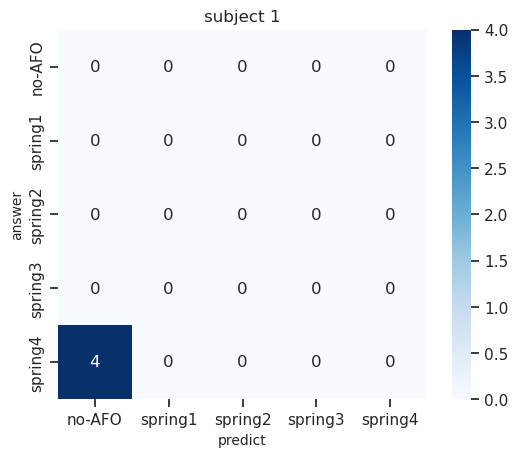

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


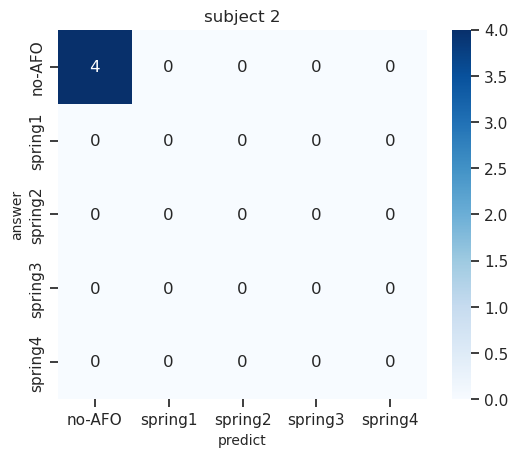

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


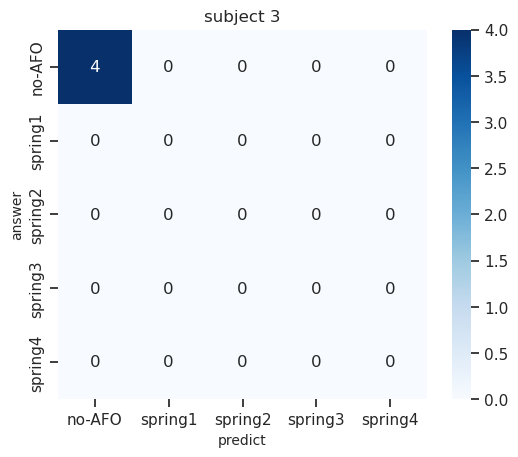

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


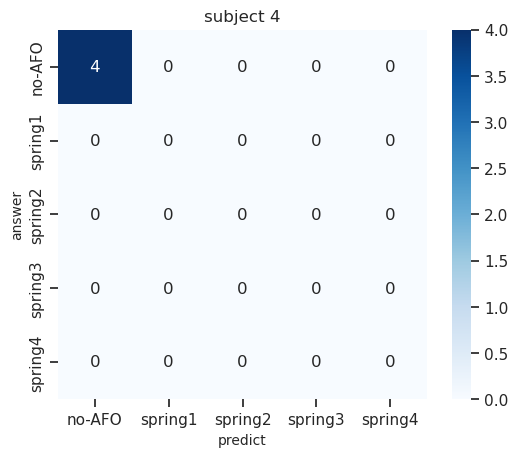

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


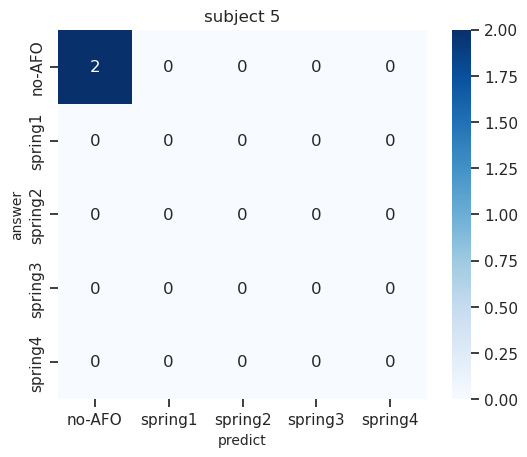

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


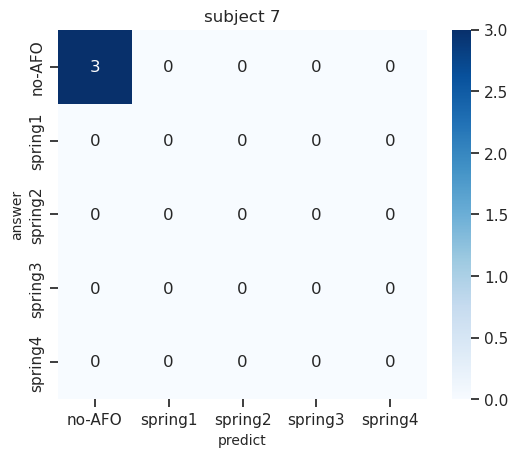

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


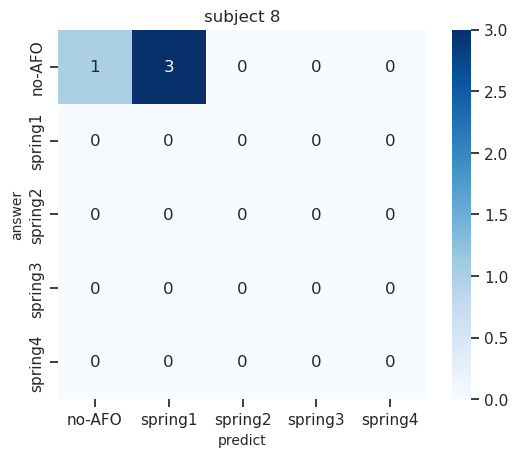

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


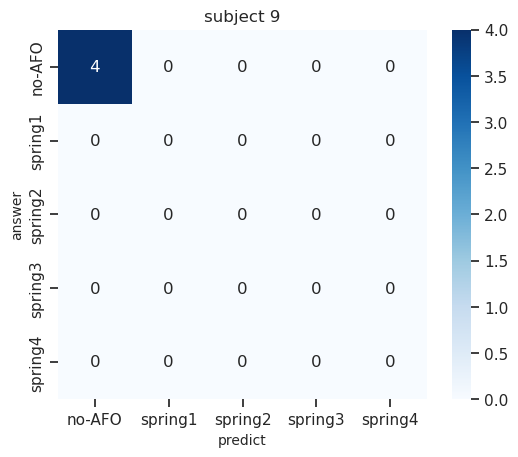

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


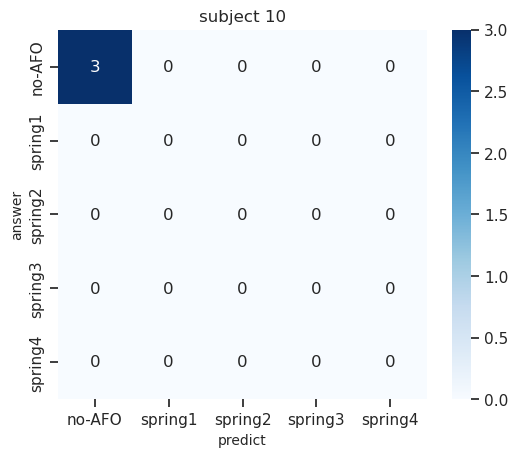

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


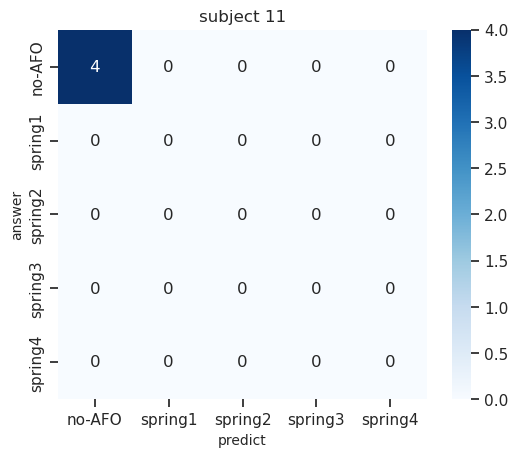

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


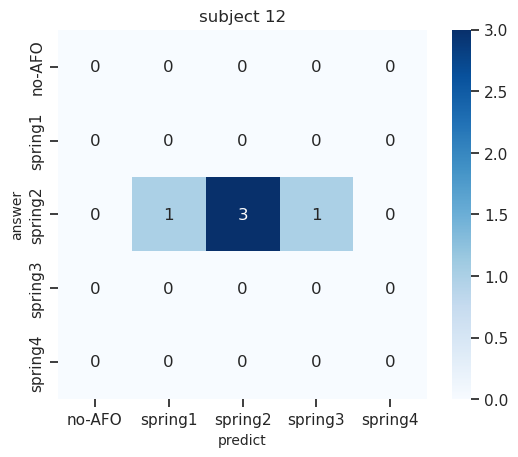

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


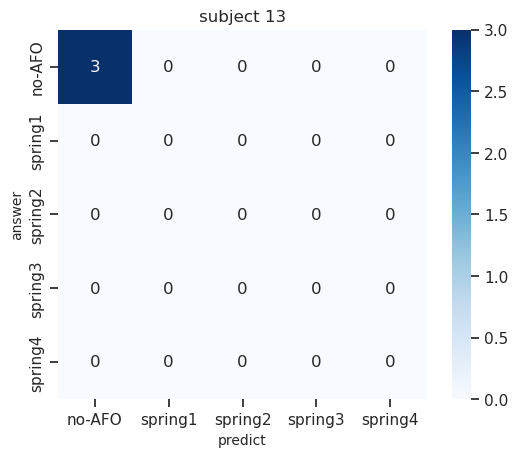

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


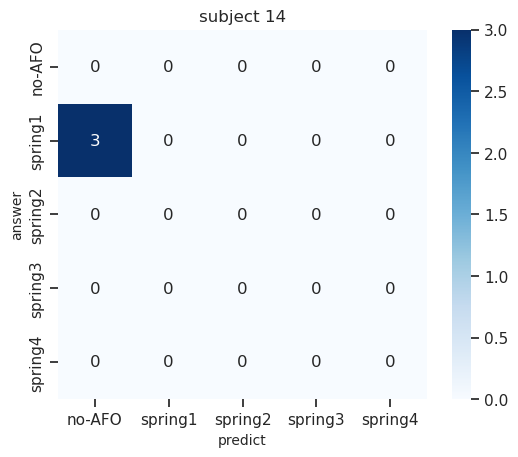

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


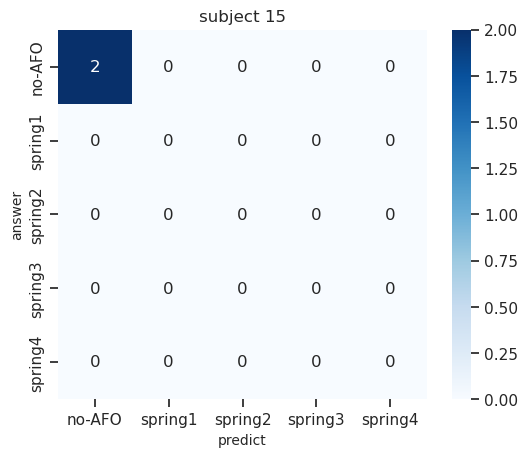

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


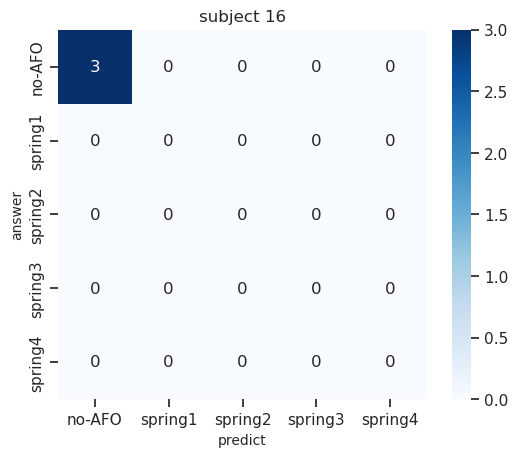

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


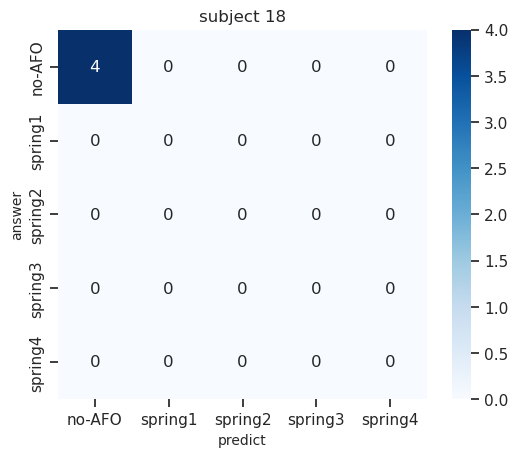

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


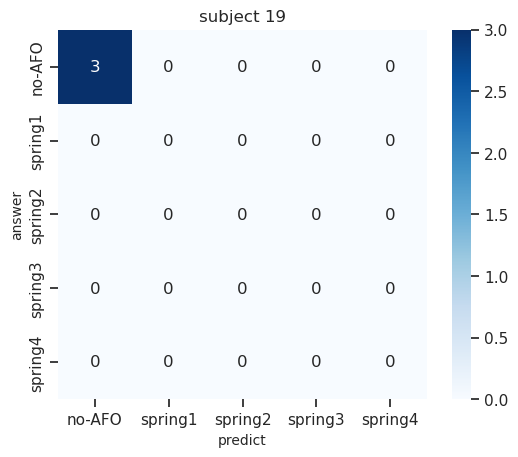

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


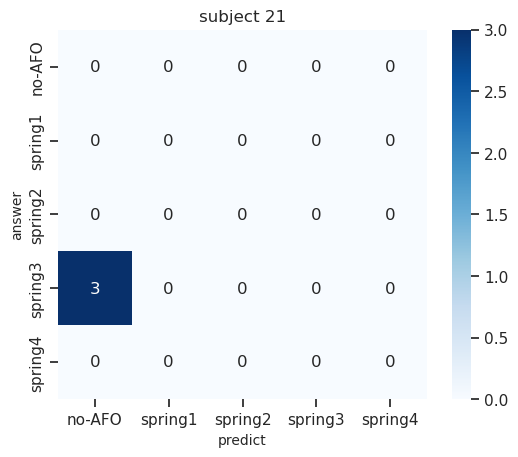

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


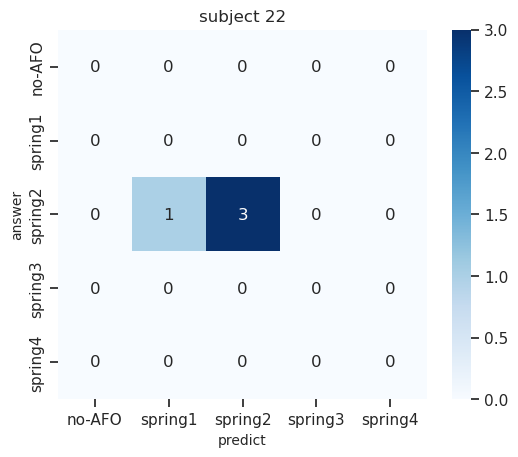

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


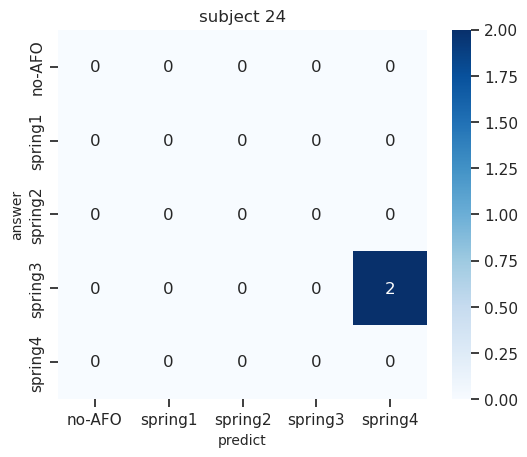

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


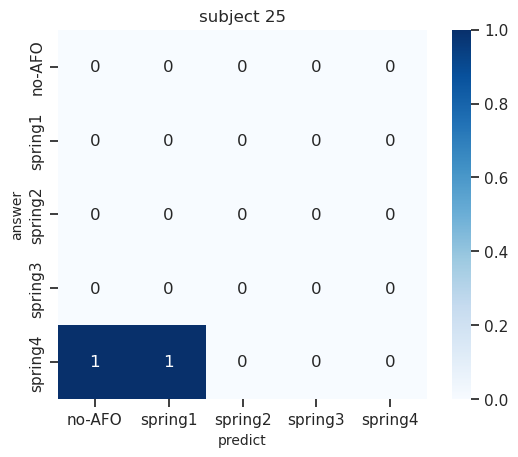

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


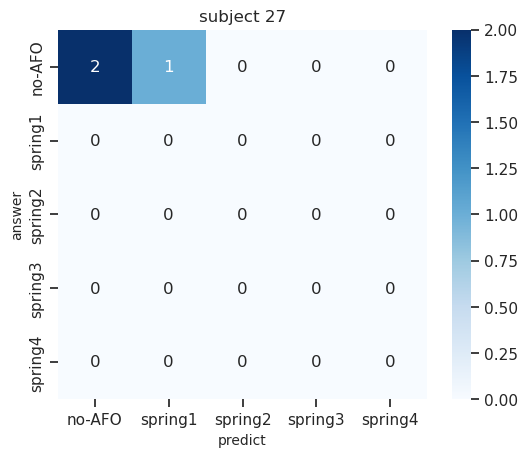

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


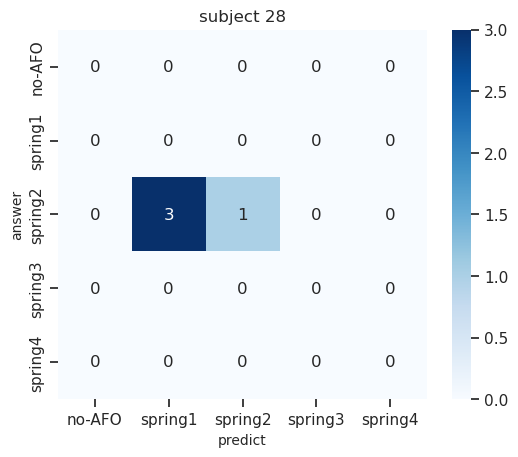

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


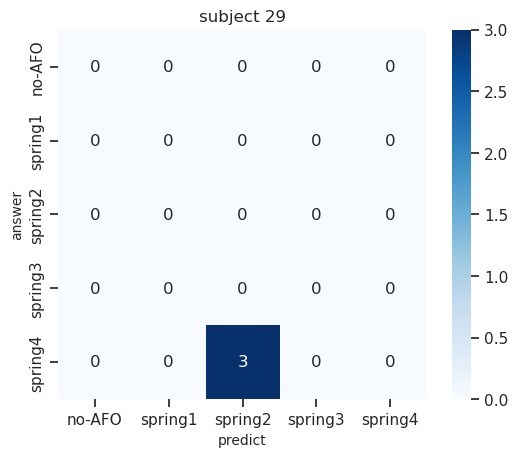

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


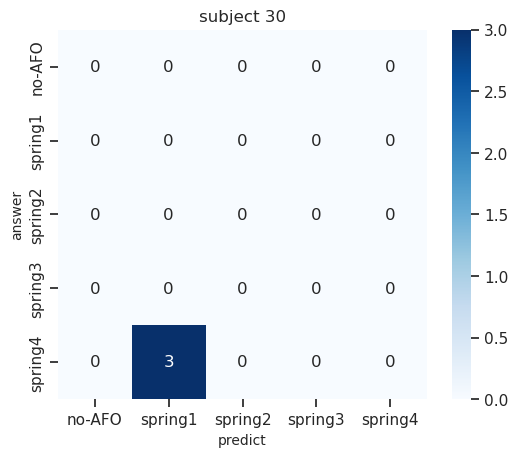

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


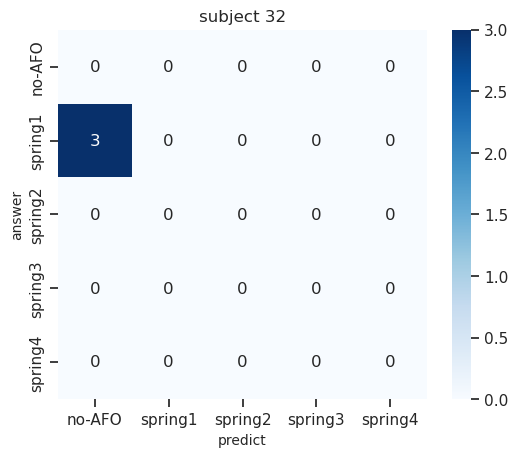

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


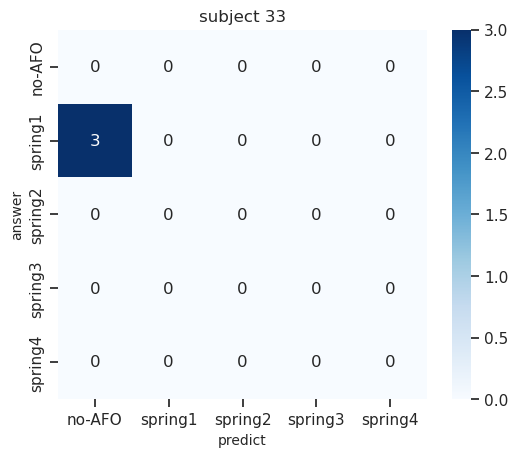

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


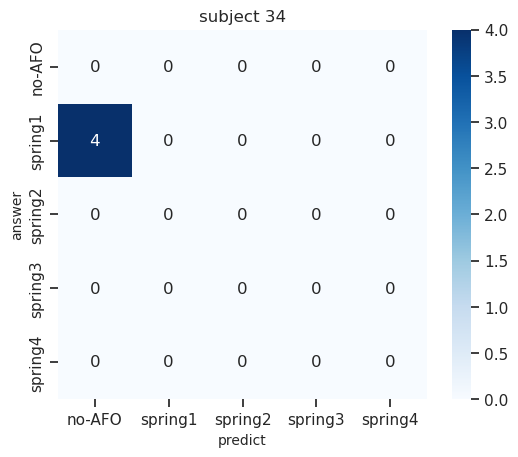

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


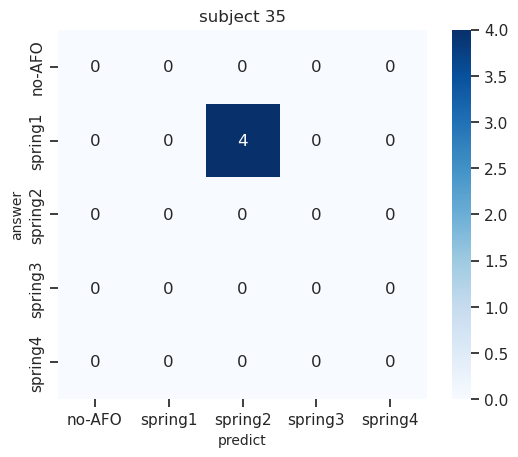

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


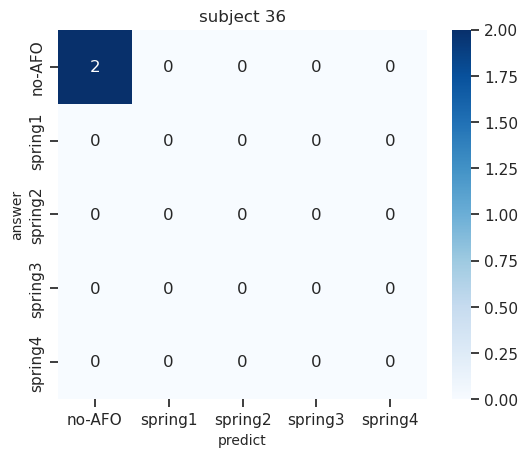

['no-AFO', 'spring1', 'spring2', 'spring3', 'spring4']


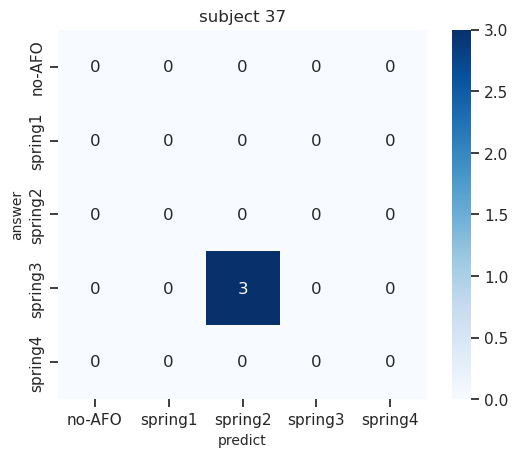

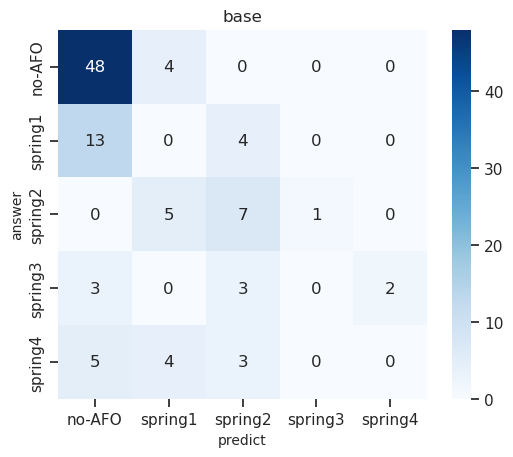

0.5392156862745098


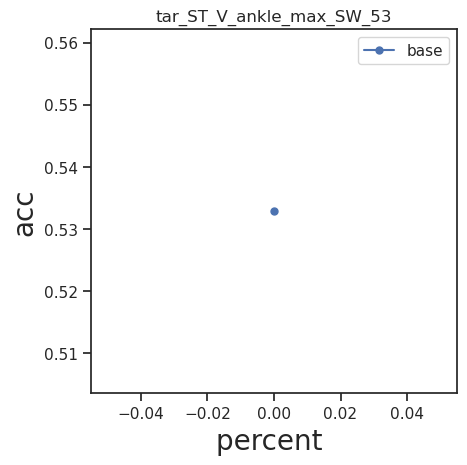

503.39579343795776


In [18]:
for each_condition in try_condition:
    targaet_dir_name=""
    
    
    
    ####使用しないデータのリスト
    drop_param_lis=each_condition[0]
    
    ###正解データとして使用する指標の組み合わせのリスト
    choose_ind_lis=each_condition[1]
    print(drop_param_lis,choose_ind_lis)

    for tar_name_tmp in choose_ind_lis:
        targaet_dir_name=targaet_dir_name+tar_name_tmp+"_"
        
    
    time_sta = time.time()
    
    ####使用するパラメータの確認
    param_lis=[]
    if len(drop_param_lis)==0:
        param_lis=copy.deepcopy(param_base)
    else:
        for i in param_base :
            if i not in drop_param_lis:
                param_lis.append(i)

    print("use ",param_lis)

    ####結果を格納するファイルの名前のもと
    dir_name=str(os.getcwd())+"/Deep_learn_ind_search/{}/Res".format(targaet_dir_name)

    ####結果を格納するファイルの名前に使用する指標を追加
    for i in range(len(param_lis)):
        dir_name=dir_name+"_"+param_lis[i]
    print(dir_name)

    ####結果を格納するファイルを作成
    os.makedirs(dir_name,exist_ok=True)
    
    ###精度などを格納するリスト
    acc=[]
    cls_report=[]

    ##########################
    
    
    #######学習をBorutaにおけるPercを変更しながら実行
    for percent in a:

        drop_hennsuu=[]

        df_b=list_df[0].copy()
        
        #####数値に変換したり,いらない指標を取り除く
        df_b['下肢BRS']=df_b['下肢BRS'].replace({'Ⅴ':5,'Ⅳ':4,'Ⅲ':3,'Ⅱ':2})
        df_b['足MAS 背屈時']=df_b['足MAS 背屈時'].replace({'0':0,'1':1,'1+':2})
        df_b['膝MAS 伸展時']=df_b['膝MAS 伸展時'].replace({'0':0,'1':1,'1+':2})
        df_b=df_b.replace({'H':0,'F':1})
        drop_hennsuu=["subject"]  
        if "deg" in drop_param_lis:
            drop_hennsuu.extend(deg_index)    
        if "ST" in drop_param_lis:
            drop_hennsuu.extend(ST_index)
        if "base" in drop_param_lis:
            drop_hennsuu.extend(base_index)
            
        ###########################################################

        ####入力データ作成
        X=df_b.drop(labels=drop_hennsuu,axis=1)

        #####指標名
        name=X.columns


        print(len(name))
        print((name))


        cou=0




        tar="tar"
        ###正解データ作成################################################################################
        df_tar2=pd.DataFrame(np.zeros((len(list_df[0].groupby("subject").mean()["V"].index), 5)),columns=["no-AFO","spring1","spring2","spring3","spring4"],index=list_df[0].groupby("subject").mean()["V"].index)
        for ind in choose_ind_lis:
            df_tar2=df_tar2+make5per(ind)
            tar=tar+"_"+ind

        df_tar2["tar"]=pd.DataFrame(df_tar2.idxmax(axis=1),columns=["tar"])
        df_tar2["subject"]=df_tar2.index
        df_tar2.index=range(len(df_tar2.index))
        df_tar2=pd.merge(list_df[0].copy()["subject"],df_tar2)
        
        ###########################################################################################
        
        
        



#     ########################TSNEを実行####################
#         tsne = TSNE(n_components=2, random_state = 0, perplexity = 20, n_iter = 5000)
#         X_embedded = tsne.fit_transform(X)    
#         tsne_ind=df_tar2.copy()["tar"]

#         ddf = pd.concat([tsne_ind.replace({'no-AFO': "no", 'spring3': "strong", 'spring1': "weak", 'spring4': "strong", 'spring2': "weak"}), pd.DataFrame(X_embedded, columns = ['col1', 'col2'])], axis = 1)

#         article_list =sorted(ddf["tar"].unique())
#         i=0
#         mar=['*','X','+','s','8',"1"]



#         plt.figure(figsize = (10, 10))
#         plt.title(tar)
#         for i , v in enumerate(article_list):
#             tmp_df = ddf[ddf["tar"] == v]
#             plt.plot(tmp_df['col1'],
#                         tmp_df['col2'],marker=mar[i%6],linestyle='', ms=8,
#                         label = v)

#             i=i+1
#         plt.legend()
#         plt.show()    
#     #############################################################


        y=df_tar2["tar"]
        kind=sorted(set(y))
        groups=list_df[0].copy()["subject"]
        logo=LeaveOneGroupOut()
        logo2=GroupKFold(n_splits=10)

        acc_tmp=[]
        pre_base=[]
        cls_report_tmp=[]

        ans=[]
        ans_name="{}/".format(dir_name)
        os.makedirs(ans_name,exist_ok=True)
        y.value_counts().to_csv("{}/answer_distribution.csv".format(ans_name))
        #######leave one 交差検証で学習
        for train, test in logo.split(X, y, groups=groups):
            
            
            
            name=X.columns
            cou=cou+1
            X_train=X.iloc[train,:]
            y_train=y.iloc[train]
            train_sub=groups.iloc[train]
            X_test=X.iloc[test,:]
            y_test=y.iloc[test]
            

            
            ans.extend(y_test.to_list())



            ########################前処理なし,ランダムフォレストで学習###############################
            rf1=GridSearchCV(estimator=RandomForestClassifier(random_state=42),param_grid = paramters2,cv=logo2.split(X_train, y_train, groups=train_sub), n_jobs=-1,return_train_score=True)

            rf1.fit(X_train.values, y_train.values)

                        
            y_test_pred = rf1.predict(X_test.values)
    
            cls_report_tmp.append(pd.DataFrame(classification_report(y_test, y_test_pred,output_dict=True,zero_division=0)))
            acc_tmp.append(accuracy_score(y_test, y_test_pred))

            pre_base.extend(y_test_pred)
            
            print(kind)
            
            tree_name="{}".format(dir_name)
            os.makedirs(tree_name,exist_ok=True)
            ###ランダムフォレストの木を描画
            for num_t in range(rf1.best_params_["n_estimators"]):

                estimator = rf1.best_estimator_[num_t]
                filename = tree_name+"/sub{}_Randomtree".format(list(groups.iloc[test])[0])+str(num_t+1)+"_max{}".format(rf1.best_params_["max_depth"])+".png"
                dot_data = tree.export_graphviz( estimator,
                        feature_names=name,
                        class_names=kind,

                        filled=True, 
                        rounded=True)
                graph = pydotplus.graph_from_dot_data( dot_data )
                graph.set_fontname('Noto Sans CJK JP')

                #Setting font for Node 
                for node in graph.get_nodes():
                    node.set_fontname('Noto Sans CJK JP')

                #Setting font for Edges 
                for e in graph.get_edges():
                    e.set_fontname('Noto Sans CJK JP')


                if num_t+1 ==3:
                    break

                graph.write_png(filename)



            ###特徴量重要度を出力   
            plt.rcParams['font.family'] = 'Noto Sans CJK JP'
            fea_rf_imp = pd.DataFrame({'imp':rf1.best_estimator_.feature_importances_, 'col': name})
            fea_rf_imp = fea_rf_imp.sort_values(by='imp', ascending=False)
            pd.DataFrame([fea_rf_imp["col"].values,fea_rf_imp["imp"].values]).to_excel("{}/sub_{}_Feater_import.xlsx".format(tree_name,list(groups.iloc[test])[0]))
            
            ######予測結果を出力
            fig=plt.figure()
            cm = conf_mat_jisaku(y_test.to_list(), y_test_pred)
            cm = pd.DataFrame(data=cm,index=kind,columns=kind)
            sns.set_theme(style="ticks", font_scale=1)
            sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
            plt.xlabel("predict",fontsize = 10)
            plt.ylabel("answer",fontsize = 10)
            plt.title("subject {}".format(list(groups.iloc[test])[0]))
            plt.show()
            fig.savefig('{}/sub_{}_confusion_matrix.png'.format( tree_name,list(set(groups.iloc[test].values))[0] ),dpi=300)

            ####################################################################################################
            
            
            
            



        cls_report.append(df_sum(cls_report_tmp))
        pd.DataFrame(df_sum(cls_report_tmp)).to_excel("{}/perc_{}_base_report.xlsx".format(dir_name,percent))

    
                    
        acc.append(sum(acc_tmp)/len(acc_tmp))

        
        fig=plt.figure()
        plt.title("base")
        cm = conf_mat_jisaku(ans,pre_base)
        cm = pd.DataFrame(data=cm,index=kind,columns=kind)
        sns.set_theme(style="ticks", font_scale=1)
        sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
        plt.xlabel("predict",fontsize = 10)
        plt.ylabel("answer",fontsize = 10)
        plt.show()
        print(accuracy_score(ans,pre_base))
        

        fig=plt.figure(figsize=(12/2.54,12/2.54))
        tar=tar+"_"+str(int(acc[0]*100))
        plt.title(tar)
        plt.plot(a,acc, marker="o",markersize=5,label="base")
        plt.xlabel("percent ",fontsize = 20)
        plt.ylabel("acc",fontsize = 20)
        plt.legend()
        plt.show()
        per_fig_n=dir_name+"/5kind_"+tar+'_acc.png'
        fig.savefig(per_fig_n)  
        time_end= time.time()
        # 経過時間（秒）
        tim = time_end- time_sta
        print(tim)
      


In [ ]:
acc[0]